In [90]:
import sys
from time import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

### Load the measurements and production data.

In [231]:
# specify time range and number of production events
time_range_key = '1m'
prod_count = 1000 if time_range_key == '1y' else 100 if time_range_key == '1m' else 50 if time_range_key == '1w' else 10

In [232]:
# all data will be read from or stored under this folder
DATA_DIR = Path('data')

measurements_file = DATA_DIR / F"measurements-dummy-{time_range_key}.csv"
prod_file = DATA_DIR / F"production-dummy-{prod_count}-{time_range_key}.csv"

In [233]:
measure_df = pd.read_csv(measurements_file)
measure_df['timestamp'] = measure_df['timestamp'].apply(lambda x: pd.Timestamp(x))
measure_df.head()

,timestamp,m1,m2,m3,m4,m5
0,2018-01-01 00:00:00,45.683661,52.420593,59.400294,40.030190,96.300961
1,2018-01-01 00:00:30,42.990597,79.721912,50.352366,63.790588,75.841581
2,2018-01-01 00:01:00,61.676567,34.413295,66.687475,60.335066,49.336322
3,2018-01-01 00:01:30,37.654645,50.728754,63.674215,41.583808,30.358239
4,2018-01-01 00:02:00,40.112285,39.179975,55.683938,41.277460,54.147361


In [234]:
prod_df = pd.read_csv(prod_file)
prod_df['finished_time'] = prod_df['finished_time'].apply(lambda x: pd.Timestamp(x))
prod_df.head()

,duration,finished_time,efficiency
0,90,2018-01-03 03:01:08,24.321626
1,90,2018-01-04 01:31:38,63.465919
2,90,2018-01-05 04:32:14,45.496554
3,90,2018-01-05 21:02:36,99.363641
4,90,2018-01-12 06:06:00,71.526070


### Merge v1

In [219]:
nano2sec = lambda x: x / 10 ** 9 # convert nanoseconds to seconds
nano2milli = lambda x: x / 10 ** 6  # convert nanoseconds to milliseconds

def merge_v1(ts, prod_df):
    '''
    add to each measurement the production finished time
    if (measure.timestamp > finished_time - duration) and (measure.timestamp < finished_time)
    '''
    t0 = pd.Timestamp.now()
    prod_results = prod_df.loc[(ts <= prod_df.finished_time) & (ts >= prod_df.finished_time - pd.Timedelta(minutes=90))]
    t = nano2milli((pd.Timestamp.now() - t0).value)    
    i = prod_df.shape[0]
    if prod_results.size == 0:
        return pd.Series({'finished_time': None, 'debug_time_ms': t, 'iter':i})
    else:
        return pd.Series({'finished_time': prod_results.iloc[0].finished_time, 'debug_time_ms': t, 'iter':i})

def merge_v2(ts, prod_df):
    '''
    add to each measurement the production finished time
    if (measure.timestamp > finished_time - duration) and (measure.timestamp < finished_time)
    '''
    t0 = pd.Timestamp.now()
    # loop over prod_df
    i = 0
    for row in prod_df.itertuples():
        i += 1
        # check if ts is in range
        finished_time = row.finished_time
        if ts <= finished_time and ts >= finished_time - pd.Timedelta(minutes=90):
            # Found! Return this finished_time
            t = nano2milli((pd.Timestamp.now() - t0).value)
            return pd.Series({'finished_time': finished_time, 'debug_time_ms': t, 'iter':i})
    
    # Not found! return None
    t = nano2milli((pd.Timestamp.now() - t0).value)
    return pd.Series({'finished_time': None, 'debug_time_ms': t, 'iter':i})

def merge_v3(ts, prod_df):
    '''
    add to each measurement the production finished time
    if (measure.timestamp > finished_time - duration) and (measure.timestamp < finished_time)
    '''
    global index_start
    t0 = pd.Timestamp.now()
    # loop over prod_df
    i = 0
    for row in prod_df[index_start:].itertuples():
        i += 1
        # check if ts is in range
        finished_time = row.finished_time
        if ts <= finished_time and ts >= finished_time - pd.Timedelta(minutes=90):
            # Found! Return this finished_time
            t = nano2milli((pd.Timestamp.now() - t0).value)
            # update the index start for the next search
            index_start = row.Index
            return pd.Series({'finished_time': finished_time, 'debug_time_ms': t, 'iter':i})
    
    # Not found! return None
    t = nano2milli((pd.Timestamp.now() - t0).value)
    return pd.Series({'finished_time': None, 'debug_time_ms': t, 'iter':i})
    
def test_merge(prod_df, measure_df, merge_func):
    # clone measurements
    measure_df2 = measure_df.copy()    
    # measure total time
    t0 = pd.Timestamp.now()
    # merge
    measure_df2[['finished_time', 'debug_time_ms', 'iter']] = measure_df2['timestamp'].apply(lambda ts: merge_func(ts, prod_df))
    # total time in seconds
    t = (pd.Timestamp.now() - t0).value
    # print stats
    print('>> Done!')
    print('  >> Total time: {0:.4f}s'.format(nano2sec(t)))
    print('  >> Time per measurement: {0:.4f}s'.format(nano2milli(t) / measure_df2.shape[0]))
    desc = measure_df2.describe(percentiles=[.25, .5, .75, .9, .95, .99])
    print('  >> Mean time: {0}'.format(desc['debug_time_ms'].loc['mean']))
    print('  >> Max time: {0}'.format(desc['debug_time_ms'].loc['max']))
    print('  >> Time at 25%: {0}'.format(desc['debug_time_ms'].loc['25%']))
    print('  >> Time at 50%: {0}'.format(desc['debug_time_ms'].loc['50%']))
    print('  >> Time at 75%: {0}'.format(desc['debug_time_ms'].loc['75%']))
    print('  >> Time at 90%: {0}'.format(desc['debug_time_ms'].loc['90%']))
    print('  >> Time at 95%: {0}'.format(desc['debug_time_ms'].loc['95%']))
    print('  >> Time at 95%: {0}'.format(desc['debug_time_ms'].loc['99%']))
    print('  >> Mean iter: {0}'.format(desc['iter'].loc['mean']))
    print('  >> Min iter: {0}'.format(desc['iter'].loc['min']))
    print('  >> Max iter: {0}'.format(desc['iter'].loc['max']))
    
    # plot
    sns.set(style="darkgrid")
    sns.set(rc={'figure.figsize':(20, 5)})
    plt.ylim(0, 15)
    sns.lineplot(x="timestamp", y="debug_time_ms", data=measure_df2)
    
    # select mesurements with merged finished time
    merged_df = measure_df2[measure_df2.finished_time.notnull()]
    merge_desc = merged_df.groupby('finished_time').size().describe()

    print('>> Merged stats:')
    print('  >> Number of production events: {0}'.format(merge_desc.loc['count']))
    print('  >> Number of measurements per event: {0}'.format(merge_desc.loc['mean']))
        
    return merged_df

#### Test merge_v1

In [ ]:
merged_v1_df = test_merge(prod_df, measure_df, merge_func=merge_v1)
merged_v1_df.head()

#### Test merge_v2

In [ ]:
merged_v2_df = test_merge(prod_df, measure_df, merge_func=merge_v2)
merged_v2_df.head()

#### Test merge_v3

In [ ]:
index_start = 0
merged_v2_df = test_merge(prod_df, measure_df, merge_func=merge_v3)
merged_v2_df.head()

In [218]:
### test
index_start = 0
measure_df2 = measure_df.copy()
measure_df2[['finished_time', 'debug_time_ms', 'iter']] = measure_df2['timestamp'].apply(lambda ts: merge_v3(ts, prod_df))
merged_df = measure_df2[measure_df2.finished_time.notnull()]
merge_desc = merged_df.groupby('finished_time').size().describe()
print(merge_desc)
merged_df.head()

Found! ts: 2018-01-01 01:30:30, finished_time: 2018-01-01 03:00:04, i: 1, index_start: 0, row: Pandas(Index=0, duration=90, finished_time=Timestamp('2018-01-01 03:00:04'), efficiency=51.10876156282436)
Found! ts: 2018-01-01 01:31:00, finished_time: 2018-01-01 03:00:04, i: 1, index_start: 0, row: Pandas(Index=0, duration=90, finished_time=Timestamp('2018-01-01 03:00:04'), efficiency=51.10876156282436)
Found! ts: 2018-01-01 01:31:30, finished_time: 2018-01-01 03:00:04, i: 1, index_start: 0, row: Pandas(Index=0, duration=90, finished_time=Timestamp('2018-01-01 03:00:04'), efficiency=51.10876156282436)
Found! ts: 2018-01-01 01:32:00, finished_time: 2018-01-01 03:00:04, i: 1, index_start: 0, row: Pandas(Index=0, duration=90, finished_time=Timestamp('2018-01-01 03:00:04'), efficiency=51.10876156282436)
Found! ts: 2018-01-01 01:32:30, finished_time: 2018-01-01 03:00:04, i: 1, index_start: 0, row: Pandas(Index=0, duration=90, finished_time=Timestamp('2018-01-01 03:00:04'), efficiency=51.108761

Found! ts: 2018-01-01 02:21:30, finished_time: 2018-01-01 03:00:04, i: 1, index_start: 0, row: Pandas(Index=0, duration=90, finished_time=Timestamp('2018-01-01 03:00:04'), efficiency=51.10876156282436)
Found! ts: 2018-01-01 02:22:00, finished_time: 2018-01-01 03:00:04, i: 1, index_start: 0, row: Pandas(Index=0, duration=90, finished_time=Timestamp('2018-01-01 03:00:04'), efficiency=51.10876156282436)
Found! ts: 2018-01-01 02:22:30, finished_time: 2018-01-01 03:00:04, i: 1, index_start: 0, row: Pandas(Index=0, duration=90, finished_time=Timestamp('2018-01-01 03:00:04'), efficiency=51.10876156282436)
Found! ts: 2018-01-01 02:23:00, finished_time: 2018-01-01 03:00:04, i: 1, index_start: 0, row: Pandas(Index=0, duration=90, finished_time=Timestamp('2018-01-01 03:00:04'), efficiency=51.10876156282436)
Found! ts: 2018-01-01 02:23:30, finished_time: 2018-01-01 03:00:04, i: 1, index_start: 0, row: Pandas(Index=0, duration=90, finished_time=Timestamp('2018-01-01 03:00:04'), efficiency=51.108761

Found! ts: 2018-01-01 03:11:00, finished_time: 2018-01-01 04:30:06, i: 1, index_start: 1, row: Pandas(Index=1, duration=90, finished_time=Timestamp('2018-01-01 04:30:06'), efficiency=27.20329450583286)
Found! ts: 2018-01-01 03:11:30, finished_time: 2018-01-01 04:30:06, i: 1, index_start: 1, row: Pandas(Index=1, duration=90, finished_time=Timestamp('2018-01-01 04:30:06'), efficiency=27.20329450583286)
Found! ts: 2018-01-01 03:12:00, finished_time: 2018-01-01 04:30:06, i: 1, index_start: 1, row: Pandas(Index=1, duration=90, finished_time=Timestamp('2018-01-01 04:30:06'), efficiency=27.20329450583286)
Found! ts: 2018-01-01 03:12:30, finished_time: 2018-01-01 04:30:06, i: 1, index_start: 1, row: Pandas(Index=1, duration=90, finished_time=Timestamp('2018-01-01 04:30:06'), efficiency=27.20329450583286)
Found! ts: 2018-01-01 03:13:00, finished_time: 2018-01-01 04:30:06, i: 1, index_start: 1, row: Pandas(Index=1, duration=90, finished_time=Timestamp('2018-01-01 04:30:06'), efficiency=27.203294

Found! ts: 2018-01-01 04:01:00, finished_time: 2018-01-01 04:30:06, i: 1, index_start: 1, row: Pandas(Index=1, duration=90, finished_time=Timestamp('2018-01-01 04:30:06'), efficiency=27.20329450583286)
Found! ts: 2018-01-01 04:01:30, finished_time: 2018-01-01 04:30:06, i: 1, index_start: 1, row: Pandas(Index=1, duration=90, finished_time=Timestamp('2018-01-01 04:30:06'), efficiency=27.20329450583286)
Found! ts: 2018-01-01 04:02:00, finished_time: 2018-01-01 04:30:06, i: 1, index_start: 1, row: Pandas(Index=1, duration=90, finished_time=Timestamp('2018-01-01 04:30:06'), efficiency=27.20329450583286)
Found! ts: 2018-01-01 04:02:30, finished_time: 2018-01-01 04:30:06, i: 1, index_start: 1, row: Pandas(Index=1, duration=90, finished_time=Timestamp('2018-01-01 04:30:06'), efficiency=27.20329450583286)
Found! ts: 2018-01-01 04:03:00, finished_time: 2018-01-01 04:30:06, i: 1, index_start: 1, row: Pandas(Index=1, duration=90, finished_time=Timestamp('2018-01-01 04:30:06'), efficiency=27.203294

Found! ts: 2018-01-01 04:49:00, finished_time: 2018-01-01 06:00:08, i: 1, index_start: 2, row: Pandas(Index=2, duration=90, finished_time=Timestamp('2018-01-01 06:00:08'), efficiency=98.80632163434716)
Found! ts: 2018-01-01 04:49:30, finished_time: 2018-01-01 06:00:08, i: 1, index_start: 2, row: Pandas(Index=2, duration=90, finished_time=Timestamp('2018-01-01 06:00:08'), efficiency=98.80632163434716)
Found! ts: 2018-01-01 04:50:00, finished_time: 2018-01-01 06:00:08, i: 1, index_start: 2, row: Pandas(Index=2, duration=90, finished_time=Timestamp('2018-01-01 06:00:08'), efficiency=98.80632163434716)
Found! ts: 2018-01-01 04:50:30, finished_time: 2018-01-01 06:00:08, i: 1, index_start: 2, row: Pandas(Index=2, duration=90, finished_time=Timestamp('2018-01-01 06:00:08'), efficiency=98.80632163434716)
Found! ts: 2018-01-01 04:51:00, finished_time: 2018-01-01 06:00:08, i: 1, index_start: 2, row: Pandas(Index=2, duration=90, finished_time=Timestamp('2018-01-01 06:00:08'), efficiency=98.806321

Found! ts: 2018-01-01 05:35:30, finished_time: 2018-01-01 06:00:08, i: 1, index_start: 2, row: Pandas(Index=2, duration=90, finished_time=Timestamp('2018-01-01 06:00:08'), efficiency=98.80632163434716)
Found! ts: 2018-01-01 05:36:00, finished_time: 2018-01-01 06:00:08, i: 1, index_start: 2, row: Pandas(Index=2, duration=90, finished_time=Timestamp('2018-01-01 06:00:08'), efficiency=98.80632163434716)
Found! ts: 2018-01-01 05:36:30, finished_time: 2018-01-01 06:00:08, i: 1, index_start: 2, row: Pandas(Index=2, duration=90, finished_time=Timestamp('2018-01-01 06:00:08'), efficiency=98.80632163434716)
Found! ts: 2018-01-01 05:37:00, finished_time: 2018-01-01 06:00:08, i: 1, index_start: 2, row: Pandas(Index=2, duration=90, finished_time=Timestamp('2018-01-01 06:00:08'), efficiency=98.80632163434716)
Found! ts: 2018-01-01 05:37:30, finished_time: 2018-01-01 06:00:08, i: 1, index_start: 2, row: Pandas(Index=2, duration=90, finished_time=Timestamp('2018-01-01 06:00:08'), efficiency=98.806321

Found! ts: 2018-01-01 07:30:30, finished_time: 2018-01-01 09:00:12, i: 2, index_start: 3, row: Pandas(Index=3, duration=90, finished_time=Timestamp('2018-01-01 09:00:12'), efficiency=50.76343671563838)
Found! ts: 2018-01-01 07:31:00, finished_time: 2018-01-01 09:00:12, i: 1, index_start: 3, row: Pandas(Index=3, duration=90, finished_time=Timestamp('2018-01-01 09:00:12'), efficiency=50.76343671563838)
Found! ts: 2018-01-01 07:31:30, finished_time: 2018-01-01 09:00:12, i: 1, index_start: 3, row: Pandas(Index=3, duration=90, finished_time=Timestamp('2018-01-01 09:00:12'), efficiency=50.76343671563838)
Found! ts: 2018-01-01 07:32:00, finished_time: 2018-01-01 09:00:12, i: 1, index_start: 3, row: Pandas(Index=3, duration=90, finished_time=Timestamp('2018-01-01 09:00:12'), efficiency=50.76343671563838)
Found! ts: 2018-01-01 07:32:30, finished_time: 2018-01-01 09:00:12, i: 1, index_start: 3, row: Pandas(Index=3, duration=90, finished_time=Timestamp('2018-01-01 09:00:12'), efficiency=50.763436

Found! ts: 2018-01-01 08:23:30, finished_time: 2018-01-01 09:00:12, i: 1, index_start: 3, row: Pandas(Index=3, duration=90, finished_time=Timestamp('2018-01-01 09:00:12'), efficiency=50.76343671563838)
Found! ts: 2018-01-01 08:24:00, finished_time: 2018-01-01 09:00:12, i: 1, index_start: 3, row: Pandas(Index=3, duration=90, finished_time=Timestamp('2018-01-01 09:00:12'), efficiency=50.76343671563838)
Found! ts: 2018-01-01 08:24:30, finished_time: 2018-01-01 09:00:12, i: 1, index_start: 3, row: Pandas(Index=3, duration=90, finished_time=Timestamp('2018-01-01 09:00:12'), efficiency=50.76343671563838)
Found! ts: 2018-01-01 08:25:00, finished_time: 2018-01-01 09:00:12, i: 1, index_start: 3, row: Pandas(Index=3, duration=90, finished_time=Timestamp('2018-01-01 09:00:12'), efficiency=50.76343671563838)
Found! ts: 2018-01-01 08:25:30, finished_time: 2018-01-01 09:00:12, i: 1, index_start: 3, row: Pandas(Index=3, duration=90, finished_time=Timestamp('2018-01-01 09:00:12'), efficiency=50.763436

Found! ts: 2018-01-01 09:15:00, finished_time: 2018-01-01 10:30:14, i: 1, index_start: 4, row: Pandas(Index=4, duration=90, finished_time=Timestamp('2018-01-01 10:30:14'), efficiency=53.17258616478592)
Found! ts: 2018-01-01 09:15:30, finished_time: 2018-01-01 10:30:14, i: 1, index_start: 4, row: Pandas(Index=4, duration=90, finished_time=Timestamp('2018-01-01 10:30:14'), efficiency=53.17258616478592)
Found! ts: 2018-01-01 09:16:00, finished_time: 2018-01-01 10:30:14, i: 1, index_start: 4, row: Pandas(Index=4, duration=90, finished_time=Timestamp('2018-01-01 10:30:14'), efficiency=53.17258616478592)
Found! ts: 2018-01-01 09:16:30, finished_time: 2018-01-01 10:30:14, i: 1, index_start: 4, row: Pandas(Index=4, duration=90, finished_time=Timestamp('2018-01-01 10:30:14'), efficiency=53.17258616478592)
Found! ts: 2018-01-01 09:17:00, finished_time: 2018-01-01 10:30:14, i: 1, index_start: 4, row: Pandas(Index=4, duration=90, finished_time=Timestamp('2018-01-01 10:30:14'), efficiency=53.172586

Found! ts: 2018-01-01 10:07:00, finished_time: 2018-01-01 10:30:14, i: 1, index_start: 4, row: Pandas(Index=4, duration=90, finished_time=Timestamp('2018-01-01 10:30:14'), efficiency=53.17258616478592)
Found! ts: 2018-01-01 10:07:30, finished_time: 2018-01-01 10:30:14, i: 1, index_start: 4, row: Pandas(Index=4, duration=90, finished_time=Timestamp('2018-01-01 10:30:14'), efficiency=53.17258616478592)
Found! ts: 2018-01-01 10:08:00, finished_time: 2018-01-01 10:30:14, i: 1, index_start: 4, row: Pandas(Index=4, duration=90, finished_time=Timestamp('2018-01-01 10:30:14'), efficiency=53.17258616478592)
Found! ts: 2018-01-01 10:08:30, finished_time: 2018-01-01 10:30:14, i: 1, index_start: 4, row: Pandas(Index=4, duration=90, finished_time=Timestamp('2018-01-01 10:30:14'), efficiency=53.17258616478592)
Found! ts: 2018-01-01 10:09:00, finished_time: 2018-01-01 10:30:14, i: 1, index_start: 4, row: Pandas(Index=4, duration=90, finished_time=Timestamp('2018-01-01 10:30:14'), efficiency=53.172586

Found! ts: 2018-01-01 12:00:30, finished_time: 2018-01-01 13:30:18, i: 2, index_start: 5, row: Pandas(Index=5, duration=90, finished_time=Timestamp('2018-01-01 13:30:18'), efficiency=35.73389737817903)
Found! ts: 2018-01-01 12:01:00, finished_time: 2018-01-01 13:30:18, i: 1, index_start: 5, row: Pandas(Index=5, duration=90, finished_time=Timestamp('2018-01-01 13:30:18'), efficiency=35.73389737817903)
Found! ts: 2018-01-01 12:01:30, finished_time: 2018-01-01 13:30:18, i: 1, index_start: 5, row: Pandas(Index=5, duration=90, finished_time=Timestamp('2018-01-01 13:30:18'), efficiency=35.73389737817903)
Found! ts: 2018-01-01 12:02:00, finished_time: 2018-01-01 13:30:18, i: 1, index_start: 5, row: Pandas(Index=5, duration=90, finished_time=Timestamp('2018-01-01 13:30:18'), efficiency=35.73389737817903)
Found! ts: 2018-01-01 12:02:30, finished_time: 2018-01-01 13:30:18, i: 1, index_start: 5, row: Pandas(Index=5, duration=90, finished_time=Timestamp('2018-01-01 13:30:18'), efficiency=35.733897

Found! ts: 2018-01-01 12:51:30, finished_time: 2018-01-01 13:30:18, i: 1, index_start: 5, row: Pandas(Index=5, duration=90, finished_time=Timestamp('2018-01-01 13:30:18'), efficiency=35.73389737817903)
Found! ts: 2018-01-01 12:52:00, finished_time: 2018-01-01 13:30:18, i: 1, index_start: 5, row: Pandas(Index=5, duration=90, finished_time=Timestamp('2018-01-01 13:30:18'), efficiency=35.73389737817903)
Found! ts: 2018-01-01 12:52:30, finished_time: 2018-01-01 13:30:18, i: 1, index_start: 5, row: Pandas(Index=5, duration=90, finished_time=Timestamp('2018-01-01 13:30:18'), efficiency=35.73389737817903)
Found! ts: 2018-01-01 12:53:00, finished_time: 2018-01-01 13:30:18, i: 1, index_start: 5, row: Pandas(Index=5, duration=90, finished_time=Timestamp('2018-01-01 13:30:18'), efficiency=35.73389737817903)
Found! ts: 2018-01-01 12:53:30, finished_time: 2018-01-01 13:30:18, i: 1, index_start: 5, row: Pandas(Index=5, duration=90, finished_time=Timestamp('2018-01-01 13:30:18'), efficiency=35.733897

Found! ts: 2018-01-01 15:00:30, finished_time: 2018-01-01 16:30:22, i: 2, index_start: 6, row: Pandas(Index=6, duration=90, finished_time=Timestamp('2018-01-01 16:30:22'), efficiency=12.615962592846445)
Found! ts: 2018-01-01 15:01:00, finished_time: 2018-01-01 16:30:22, i: 1, index_start: 6, row: Pandas(Index=6, duration=90, finished_time=Timestamp('2018-01-01 16:30:22'), efficiency=12.615962592846445)
Found! ts: 2018-01-01 15:01:30, finished_time: 2018-01-01 16:30:22, i: 1, index_start: 6, row: Pandas(Index=6, duration=90, finished_time=Timestamp('2018-01-01 16:30:22'), efficiency=12.615962592846445)
Found! ts: 2018-01-01 15:02:00, finished_time: 2018-01-01 16:30:22, i: 1, index_start: 6, row: Pandas(Index=6, duration=90, finished_time=Timestamp('2018-01-01 16:30:22'), efficiency=12.615962592846445)
Found! ts: 2018-01-01 15:02:30, finished_time: 2018-01-01 16:30:22, i: 1, index_start: 6, row: Pandas(Index=6, duration=90, finished_time=Timestamp('2018-01-01 16:30:22'), efficiency=12.61

Found! ts: 2018-01-01 15:58:00, finished_time: 2018-01-01 16:30:22, i: 1, index_start: 6, row: Pandas(Index=6, duration=90, finished_time=Timestamp('2018-01-01 16:30:22'), efficiency=12.615962592846445)
Found! ts: 2018-01-01 15:58:30, finished_time: 2018-01-01 16:30:22, i: 1, index_start: 6, row: Pandas(Index=6, duration=90, finished_time=Timestamp('2018-01-01 16:30:22'), efficiency=12.615962592846445)
Found! ts: 2018-01-01 15:59:00, finished_time: 2018-01-01 16:30:22, i: 1, index_start: 6, row: Pandas(Index=6, duration=90, finished_time=Timestamp('2018-01-01 16:30:22'), efficiency=12.615962592846445)
Found! ts: 2018-01-01 15:59:30, finished_time: 2018-01-01 16:30:22, i: 1, index_start: 6, row: Pandas(Index=6, duration=90, finished_time=Timestamp('2018-01-01 16:30:22'), efficiency=12.615962592846445)
Found! ts: 2018-01-01 16:00:00, finished_time: 2018-01-01 16:30:22, i: 1, index_start: 6, row: Pandas(Index=6, duration=90, finished_time=Timestamp('2018-01-01 16:30:22'), efficiency=12.61

Found! ts: 2018-01-01 16:51:00, finished_time: 2018-01-01 18:00:24, i: 1, index_start: 7, row: Pandas(Index=7, duration=90, finished_time=Timestamp('2018-01-01 18:00:24'), efficiency=29.40069466185184)
Found! ts: 2018-01-01 16:51:30, finished_time: 2018-01-01 18:00:24, i: 1, index_start: 7, row: Pandas(Index=7, duration=90, finished_time=Timestamp('2018-01-01 18:00:24'), efficiency=29.40069466185184)
Found! ts: 2018-01-01 16:52:00, finished_time: 2018-01-01 18:00:24, i: 1, index_start: 7, row: Pandas(Index=7, duration=90, finished_time=Timestamp('2018-01-01 18:00:24'), efficiency=29.40069466185184)
Found! ts: 2018-01-01 16:52:30, finished_time: 2018-01-01 18:00:24, i: 1, index_start: 7, row: Pandas(Index=7, duration=90, finished_time=Timestamp('2018-01-01 18:00:24'), efficiency=29.40069466185184)
Found! ts: 2018-01-01 16:53:00, finished_time: 2018-01-01 18:00:24, i: 1, index_start: 7, row: Pandas(Index=7, duration=90, finished_time=Timestamp('2018-01-01 18:00:24'), efficiency=29.400694

Found! ts: 2018-01-01 17:46:30, finished_time: 2018-01-01 18:00:24, i: 1, index_start: 7, row: Pandas(Index=7, duration=90, finished_time=Timestamp('2018-01-01 18:00:24'), efficiency=29.40069466185184)
Found! ts: 2018-01-01 17:47:00, finished_time: 2018-01-01 18:00:24, i: 1, index_start: 7, row: Pandas(Index=7, duration=90, finished_time=Timestamp('2018-01-01 18:00:24'), efficiency=29.40069466185184)
Found! ts: 2018-01-01 17:47:30, finished_time: 2018-01-01 18:00:24, i: 1, index_start: 7, row: Pandas(Index=7, duration=90, finished_time=Timestamp('2018-01-01 18:00:24'), efficiency=29.40069466185184)
Found! ts: 2018-01-01 17:48:00, finished_time: 2018-01-01 18:00:24, i: 1, index_start: 7, row: Pandas(Index=7, duration=90, finished_time=Timestamp('2018-01-01 18:00:24'), efficiency=29.40069466185184)
Found! ts: 2018-01-01 17:48:30, finished_time: 2018-01-01 18:00:24, i: 1, index_start: 7, row: Pandas(Index=7, duration=90, finished_time=Timestamp('2018-01-01 18:00:24'), efficiency=29.400694

Found! ts: 2018-01-01 18:35:00, finished_time: 2018-01-01 19:30:26, i: 1, index_start: 8, row: Pandas(Index=8, duration=90, finished_time=Timestamp('2018-01-01 19:30:26'), efficiency=19.066323233872566)
Found! ts: 2018-01-01 18:35:30, finished_time: 2018-01-01 19:30:26, i: 1, index_start: 8, row: Pandas(Index=8, duration=90, finished_time=Timestamp('2018-01-01 19:30:26'), efficiency=19.066323233872566)
Found! ts: 2018-01-01 18:36:00, finished_time: 2018-01-01 19:30:26, i: 1, index_start: 8, row: Pandas(Index=8, duration=90, finished_time=Timestamp('2018-01-01 19:30:26'), efficiency=19.066323233872566)
Found! ts: 2018-01-01 18:36:30, finished_time: 2018-01-01 19:30:26, i: 1, index_start: 8, row: Pandas(Index=8, duration=90, finished_time=Timestamp('2018-01-01 19:30:26'), efficiency=19.066323233872566)
Found! ts: 2018-01-01 18:37:00, finished_time: 2018-01-01 19:30:26, i: 1, index_start: 8, row: Pandas(Index=8, duration=90, finished_time=Timestamp('2018-01-01 19:30:26'), efficiency=19.06

Found! ts: 2018-01-01 19:11:30, finished_time: 2018-01-01 19:30:26, i: 1, index_start: 8, row: Pandas(Index=8, duration=90, finished_time=Timestamp('2018-01-01 19:30:26'), efficiency=19.066323233872566)
Found! ts: 2018-01-01 19:12:00, finished_time: 2018-01-01 19:30:26, i: 1, index_start: 8, row: Pandas(Index=8, duration=90, finished_time=Timestamp('2018-01-01 19:30:26'), efficiency=19.066323233872566)
Found! ts: 2018-01-01 19:12:30, finished_time: 2018-01-01 19:30:26, i: 1, index_start: 8, row: Pandas(Index=8, duration=90, finished_time=Timestamp('2018-01-01 19:30:26'), efficiency=19.066323233872566)
Found! ts: 2018-01-01 19:13:00, finished_time: 2018-01-01 19:30:26, i: 1, index_start: 8, row: Pandas(Index=8, duration=90, finished_time=Timestamp('2018-01-01 19:30:26'), efficiency=19.066323233872566)
Found! ts: 2018-01-01 19:13:30, finished_time: 2018-01-01 19:30:26, i: 1, index_start: 8, row: Pandas(Index=8, duration=90, finished_time=Timestamp('2018-01-01 19:30:26'), efficiency=19.06

Found! ts: 2018-01-01 22:01:00, finished_time: 2018-01-01 22:30:30, i: 1, index_start: 9, row: Pandas(Index=9, duration=90, finished_time=Timestamp('2018-01-01 22:30:30'), efficiency=85.56431833188554)
Found! ts: 2018-01-01 22:01:30, finished_time: 2018-01-01 22:30:30, i: 1, index_start: 9, row: Pandas(Index=9, duration=90, finished_time=Timestamp('2018-01-01 22:30:30'), efficiency=85.56431833188554)
Found! ts: 2018-01-01 22:02:00, finished_time: 2018-01-01 22:30:30, i: 1, index_start: 9, row: Pandas(Index=9, duration=90, finished_time=Timestamp('2018-01-01 22:30:30'), efficiency=85.56431833188554)
Found! ts: 2018-01-01 22:02:30, finished_time: 2018-01-01 22:30:30, i: 1, index_start: 9, row: Pandas(Index=9, duration=90, finished_time=Timestamp('2018-01-01 22:30:30'), efficiency=85.56431833188554)
Found! ts: 2018-01-01 22:03:00, finished_time: 2018-01-01 22:30:30, i: 1, index_start: 9, row: Pandas(Index=9, duration=90, finished_time=Timestamp('2018-01-01 22:30:30'), efficiency=85.564318

count     10.000000
mean     180.100000
std        0.316228
min      180.000000
25%      180.000000
50%      180.000000
75%      180.000000
max      181.000000
dtype: float64


,timestamp,m1,m2,m3,m4,m5,finished_time,debug_time_ms,iter
181,2018-01-01 01:30:30,68.108305,74.521933,32.397499,54.095351,34.772458,2018-01-01 03:00:04,0.000,1.0
182,2018-01-01 01:31:00,41.789023,50.819777,25.278318,34.802171,43.864491,2018-01-01 03:00:04,2.055,1.0
183,2018-01-01 01:31:30,76.797885,56.761951,66.229944,55.841921,55.903782,2018-01-01 03:00:04,0.000,1.0
184,2018-01-01 01:32:00,49.333087,50.288513,63.647841,29.194204,25.185023,2018-01-01 03:00:04,0.000,1.0
185,2018-01-01 01:32:30,31.098806,51.672563,60.140801,54.277800,31.212572,2018-01-01 03:00:04,0.000,1.0


In [192]:
index_start = 0

def merge_v3(ts, prod_df):
    '''
    add to each measurement the production finished time
    if (measure.timestamp > finished_time - duration) and (measure.timestamp < finished_time)
    '''
    global index_start
    t0 = pd.Timestamp.now()
    # loop over prod_df
    for row in prod_df[index_start:].itertuples():
        # check if ts is in range
        finished_time = row.finished_time
        if ts <= finished_time and ts >= finished_time - pd.Timedelta(minutes=90):
            # Found! Return this finished_time
            t = nano2milli((pd.Timestamp.now() - t0).value)
            # update the index start for the next search
            index_start = row.Index
            return pd.Series({'finished_time': finished_time, 'debug_time_ms': t})
    
    # Not found! return None
    t = nano2milli((pd.Timestamp.now() - t0).value)
    return pd.Series({'finished_time': None, 'debug_time_ms': t})
    
measure_df2 = measure_df.copy()

t0 = pd.Timestamp.now()
measure_df2[['finished_time', 'debug_time_ms']] = measure_df2['timestamp'].apply(lambda ts: merge_v3(ts, prod_df))
t = pd.Timestamp.now() - t0
print('Total time: {0:.4f}s'.format(nano2sec(t.value)))
merged_df = measure_df2[measure_df2.finished_time.notnull()]
merge_desc = merged_df.groupby('finished_time').size().describe()
print(merge_desc)
measure_df2.head()

Total time: 5.7136s
count     10.000000
mean     180.100000
std        0.316228
min      180.000000
25%      180.000000
50%      180.000000
75%      180.000000
max      181.000000
dtype: float64


,timestamp,m1,m2,m3,m4,m5,finished_time,debug_time_ms
0,2018-01-01 00:00:00,66.780494,65.217221,48.842714,51.054600,56.330693,NaT,0.000
1,2018-01-01 00:00:30,57.675873,82.594139,67.128019,34.646194,49.404110,NaT,0.000
2,2018-01-01 00:01:00,65.254882,51.663527,49.967143,53.994720,27.718782,NaT,0.000
3,2018-01-01 00:01:30,48.868397,23.830365,63.191482,53.418901,61.711849,NaT,0.000
4,2018-01-01 00:02:00,55.270477,16.035617,46.767995,31.731472,60.183277,NaT,15.624


In [159]:
measure_df2.debug_time_ms.describe()

count    2880.000000
mean        1.299721
std         2.485081
min         0.000000
25%         0.000000
50%         0.000000
75%         2.031000
max        73.359000
Name: debug_time_ms, dtype: float64

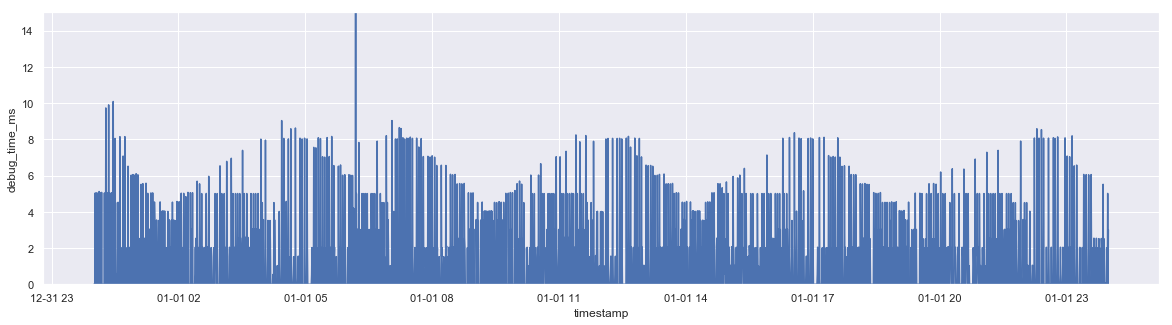

In [160]:
# plot
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(20, 5)})
plt.ylim(0, 15)
sns.lineplot(x="timestamp", y="debug_time_ms", data=measure_df2)

In [146]:
def loop1(prod_df2):
    for index, row in prod_df2.head().iterrows():
        finished_time = row['finished_time']

%timeit loop1(prod_df2)

912 µs ± 2.74 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [155]:
def loop2(prod_df2):
    for row in prod_df2.itertuples():
        finished_time = row.finished_time
        #print('?', finished_time)
        if finished_time > pd.Timestamp('2018-01-01 19:31:00'):
            print('Found:', finished_time)
            break

loop2(prod_df2)

Found: 2018-01-01 22:30:30


In [190]:
for row in prod_df[3:].itertuples():
    #finished_time = row.finished_time
    print(row.Index)

3
4
5
6
7
8
9
